# PyTorch入门与实战第六课 

褚则伟 zeweichu@gmail.com

### 目录
- 图片风格迁移 
- 用GAN生成MNIST
- 用DCGAN生成更复杂的图片

## 图片风格迁移 Neural Style Transfer 

[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)
本文介绍了Neural Style Transfor模型


[Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf)


In [1]:
%matplotlib inline

from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
         
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
]) # 来自ImageNet的mean和variance

content = load_image("png/content.png", transform, max_size=400)
stype = load_image("png/style.png", transform, shape=[content.size(2), content.size(3)])

# content = load_image("png/content.png", transforms.Compose([
#     transforms.ToTensor(),
# ]), max_size=400)
# style = load_image("png/style.png", transforms.Compose([
#     transforms.ToTensor(),
# ]), shape=[content.size(2), content.size(3)])

In [8]:
stype.shape

torch.Size([1, 3, 400, 272])

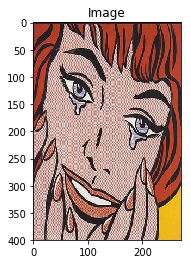

In [17]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Image')
# content.shape

In [34]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

In [35]:
target_features = vgg(target)

In [42]:
total_step = 2000
style_weight = 100.
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)
        
    loss = content_loss + style_weight * style_loss
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))

Step [0/2000], Content Loss: 0.0000, Style Loss: 531.1730
Step [10/2000], Content Loss: 6.0654, Style Loss: 360.6187
Step [20/2000], Content Loss: 11.3430, Style Loss: 253.8006
Step [30/2000], Content Loss: 14.5195, Style Loss: 190.0798
Step [40/2000], Content Loss: 16.5578, Style Loss: 152.3939
Step [50/2000], Content Loss: 17.9683, Style Loss: 129.4922
Step [60/2000], Content Loss: 19.0225, Style Loss: 114.5218
Step [70/2000], Content Loss: 19.8584, Style Loss: 103.7824
Step [80/2000], Content Loss: 20.5509, Style Loss: 95.5047
Step [90/2000], Content Loss: 21.1601, Style Loss: 88.7919
Step [100/2000], Content Loss: 21.6844, Style Loss: 83.1393
Step [110/2000], Content Loss: 22.1447, Style Loss: 78.2809
Step [120/2000], Content Loss: 22.5605, Style Loss: 74.0401
Step [130/2000], Content Loss: 22.9415, Style Loss: 70.2842
Step [140/2000], Content Loss: 23.2941, Style Loss: 66.9353
Step [150/2000], Content Loss: 23.6130, Style Loss: 63.9158
Step [160/2000], Content Loss: 23.9114, Style

Step [1370/2000], Content Loss: 32.0038, Style Loss: 9.8461
Step [1380/2000], Content Loss: 32.0191, Style Loss: 9.7687
Step [1390/2000], Content Loss: 32.0434, Style Loss: 9.6970
Step [1400/2000], Content Loss: 32.0572, Style Loss: 9.6203
Step [1410/2000], Content Loss: 32.0787, Style Loss: 9.5496
Step [1420/2000], Content Loss: 32.0955, Style Loss: 9.4771
Step [1430/2000], Content Loss: 32.1123, Style Loss: 9.4056
Step [1440/2000], Content Loss: 32.1289, Style Loss: 9.3349
Step [1450/2000], Content Loss: 32.1441, Style Loss: 9.2636
Step [1460/2000], Content Loss: 32.1628, Style Loss: 9.1949
Step [1470/2000], Content Loss: 32.1851, Style Loss: 9.1302
Step [1480/2000], Content Loss: 32.1958, Style Loss: 9.0589
Step [1490/2000], Content Loss: 32.2141, Style Loss: 8.9938
Step [1500/2000], Content Loss: 32.2303, Style Loss: 8.9282
Step [1510/2000], Content Loss: 32.2414, Style Loss: 8.8597
Step [1520/2000], Content Loss: 32.2560, Style Loss: 8.7944
Step [1530/2000], Content Loss: 32.2785,

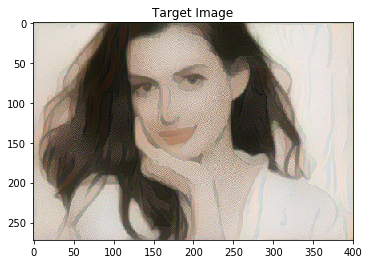

In [48]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
plt.figure()
imshow(img, title='Target Image')

## Generative Adversarial Networks

In [2]:
batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                        std=(0.5, 0.5, 0.5))
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

In [3]:
image_size = 784

hidden_size = 256
# discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64
# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

开始训练

In [5]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(dataloader)
num_epochs = 200
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.reshape(batch_size, image_size).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs
        
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs
        
        # 开始优化discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 开始优化generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels)
        
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

Epoch [0/200], Step [0/1875], d_loss: 0.6669, g_loss: 2.9577, D(x): 0.76, D(G(z)): 0.15
Epoch [0/200], Step [1000/1875], d_loss: 0.1716, g_loss: 3.0008, D(x): 0.93, D(G(z)): 0.09
Epoch [1/200], Step [0/1875], d_loss: 0.1716, g_loss: 4.1396, D(x): 0.93, D(G(z)): 0.02
Epoch [1/200], Step [1000/1875], d_loss: 0.0202, g_loss: 5.1296, D(x): 1.00, D(G(z)): 0.02
Epoch [2/200], Step [0/1875], d_loss: 0.2070, g_loss: 3.7713, D(x): 0.93, D(G(z)): 0.08
Epoch [2/200], Step [1000/1875], d_loss: 0.0829, g_loss: 4.9163, D(x): 0.99, D(G(z)): 0.07
Epoch [3/200], Step [0/1875], d_loss: 0.2986, g_loss: 3.6197, D(x): 0.90, D(G(z)): 0.03
Epoch [3/200], Step [1000/1875], d_loss: 0.4204, g_loss: 2.2956, D(x): 0.90, D(G(z)): 0.14
Epoch [4/200], Step [0/1875], d_loss: 0.4453, g_loss: 5.1677, D(x): 0.80, D(G(z)): 0.02
Epoch [4/200], Step [1000/1875], d_loss: 0.1900, g_loss: 2.7722, D(x): 0.93, D(G(z)): 0.10
Epoch [5/200], Step [0/1875], d_loss: 0.3418, g_loss: 2.4469, D(x): 1.00, D(G(z)): 0.21
Epoch [5/200], St

Epoch [45/200], Step [1000/1875], d_loss: 1.0184, g_loss: 1.2799, D(x): 0.68, D(G(z)): 0.37
Epoch [46/200], Step [0/1875], d_loss: 0.7981, g_loss: 2.0579, D(x): 0.71, D(G(z)): 0.26
Epoch [46/200], Step [1000/1875], d_loss: 1.1051, g_loss: 1.2950, D(x): 0.63, D(G(z)): 0.28
Epoch [47/200], Step [0/1875], d_loss: 0.9363, g_loss: 1.2712, D(x): 0.64, D(G(z)): 0.26
Epoch [47/200], Step [1000/1875], d_loss: 0.7284, g_loss: 1.2780, D(x): 0.82, D(G(z)): 0.36
Epoch [48/200], Step [0/1875], d_loss: 0.9353, g_loss: 1.6880, D(x): 0.76, D(G(z)): 0.41
Epoch [48/200], Step [1000/1875], d_loss: 0.9996, g_loss: 1.7311, D(x): 0.70, D(G(z)): 0.32
Epoch [49/200], Step [0/1875], d_loss: 0.9926, g_loss: 1.4112, D(x): 0.78, D(G(z)): 0.42
Epoch [49/200], Step [1000/1875], d_loss: 0.8023, g_loss: 1.6557, D(x): 0.65, D(G(z)): 0.21
Epoch [50/200], Step [0/1875], d_loss: 0.8718, g_loss: 1.9058, D(x): 0.63, D(G(z)): 0.20
Epoch [50/200], Step [1000/1875], d_loss: 0.9961, g_loss: 1.5768, D(x): 0.62, D(G(z)): 0.28
Epo

Epoch [91/200], Step [0/1875], d_loss: 1.2105, g_loss: 0.9780, D(x): 0.66, D(G(z)): 0.41
Epoch [91/200], Step [1000/1875], d_loss: 1.0656, g_loss: 1.5340, D(x): 0.60, D(G(z)): 0.32
Epoch [92/200], Step [0/1875], d_loss: 0.9305, g_loss: 1.5715, D(x): 0.64, D(G(z)): 0.28
Epoch [92/200], Step [1000/1875], d_loss: 0.8817, g_loss: 1.5210, D(x): 0.71, D(G(z)): 0.31
Epoch [93/200], Step [0/1875], d_loss: 0.8735, g_loss: 1.8431, D(x): 0.62, D(G(z)): 0.23
Epoch [93/200], Step [1000/1875], d_loss: 1.2207, g_loss: 1.4299, D(x): 0.61, D(G(z)): 0.36
Epoch [94/200], Step [0/1875], d_loss: 1.1631, g_loss: 1.6790, D(x): 0.53, D(G(z)): 0.25
Epoch [94/200], Step [1000/1875], d_loss: 1.0503, g_loss: 1.3590, D(x): 0.67, D(G(z)): 0.37
Epoch [95/200], Step [0/1875], d_loss: 0.9073, g_loss: 1.3901, D(x): 0.65, D(G(z)): 0.29
Epoch [95/200], Step [1000/1875], d_loss: 0.9264, g_loss: 1.4881, D(x): 0.70, D(G(z)): 0.36
Epoch [96/200], Step [0/1875], d_loss: 0.8375, g_loss: 1.6237, D(x): 0.68, D(G(z)): 0.28
Epoch 

Epoch [136/200], Step [0/1875], d_loss: 0.9289, g_loss: 1.2938, D(x): 0.74, D(G(z)): 0.39
Epoch [136/200], Step [1000/1875], d_loss: 0.8836, g_loss: 1.4500, D(x): 0.67, D(G(z)): 0.27
Epoch [137/200], Step [0/1875], d_loss: 0.9663, g_loss: 1.2554, D(x): 0.72, D(G(z)): 0.32
Epoch [137/200], Step [1000/1875], d_loss: 0.7621, g_loss: 1.5249, D(x): 0.70, D(G(z)): 0.26
Epoch [138/200], Step [0/1875], d_loss: 1.1226, g_loss: 1.3983, D(x): 0.62, D(G(z)): 0.37
Epoch [138/200], Step [1000/1875], d_loss: 0.8552, g_loss: 1.2803, D(x): 0.68, D(G(z)): 0.30
Epoch [139/200], Step [0/1875], d_loss: 1.1601, g_loss: 1.5479, D(x): 0.66, D(G(z)): 0.37
Epoch [139/200], Step [1000/1875], d_loss: 0.9467, g_loss: 1.3331, D(x): 0.78, D(G(z)): 0.41
Epoch [140/200], Step [0/1875], d_loss: 0.9792, g_loss: 1.6201, D(x): 0.72, D(G(z)): 0.33
Epoch [140/200], Step [1000/1875], d_loss: 1.0290, g_loss: 1.6335, D(x): 0.69, D(G(z)): 0.36
Epoch [141/200], Step [0/1875], d_loss: 0.8760, g_loss: 1.4903, D(x): 0.73, D(G(z)): 

Epoch [181/200], Step [0/1875], d_loss: 1.1119, g_loss: 1.6124, D(x): 0.72, D(G(z)): 0.37
Epoch [181/200], Step [1000/1875], d_loss: 1.1789, g_loss: 1.1550, D(x): 0.59, D(G(z)): 0.31
Epoch [182/200], Step [0/1875], d_loss: 1.0281, g_loss: 0.8599, D(x): 0.74, D(G(z)): 0.41
Epoch [182/200], Step [1000/1875], d_loss: 1.1698, g_loss: 1.5769, D(x): 0.63, D(G(z)): 0.36
Epoch [183/200], Step [0/1875], d_loss: 0.8879, g_loss: 1.2538, D(x): 0.73, D(G(z)): 0.34
Epoch [183/200], Step [1000/1875], d_loss: 0.9862, g_loss: 1.7838, D(x): 0.61, D(G(z)): 0.28
Epoch [184/200], Step [0/1875], d_loss: 0.8218, g_loss: 1.2922, D(x): 0.67, D(G(z)): 0.25
Epoch [184/200], Step [1000/1875], d_loss: 0.8309, g_loss: 1.4066, D(x): 0.81, D(G(z)): 0.36
Epoch [185/200], Step [0/1875], d_loss: 0.8038, g_loss: 1.1647, D(x): 0.68, D(G(z)): 0.25
Epoch [185/200], Step [1000/1875], d_loss: 1.1130, g_loss: 1.4807, D(x): 0.63, D(G(z)): 0.31
Epoch [186/200], Step [0/1875], d_loss: 1.3574, g_loss: 1.8987, D(x): 0.53, D(G(z)): 

fake images

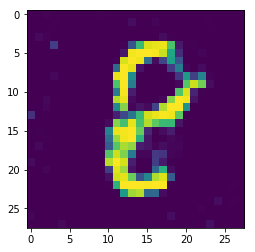

In [80]:
z = torch.randn(1, latent_size).to(device)
fake_images = G(z).view(28, 28).data.cpu().numpy()
plt.imshow(fake_images)

真实图片

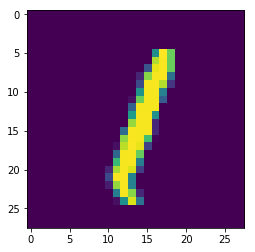

In [85]:
plt.imshow(images[0].view(28,28).data.cpu().numpy())

## DCGAN

[UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434.pdf)

[图片下载地址](https://drive.google.com/drive/folders/0B7EVK8r0v71pbWNEUjJKdDQ3dGc)
https://drive.google.com/drive/folders/0B7EVK8r0v71pbWNEUjJKdDQ3dGc

In [2]:
import torchvision.utils as vutils

In [3]:
# !ls celeba/img_align_celeba/img_align_celeba_png

In [4]:
image_size=64
batch_size=128
dataroot="celeba/img_align_celeba"
num_workers = 2
dataset = torchvision.datasets.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

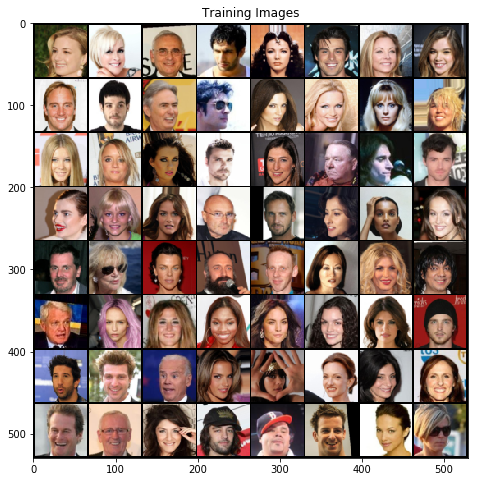

In [5]:
real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis=("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

我们把模型的所有参数都初始化城mean=0, std=0.2

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![dcgan](images/dcgan_generator.png)

In [7]:
nz = 100 # latent vector的大小
ngf = 64 # generator feature map size
ndf = 64 # discriminator feature map size
nc = 3 # color channels

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # torch.nn.ConvTranspose2d(in_channels, out_channels, 
            # kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Now, as with the generator, we can create the discriminator, apply the weights_init function, and print the model’s structure.

# Create the Discriminator
netD = Discriminator().to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)



开始训练

In [11]:
lr = 0.0002
beta1 = 0.5

loss_fn = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
d_optimizer = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
num_epochs = 5
G_losses = []
D_losses = []
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        # 训练discriminator, maximize log(D(x)) + log(1-D(G(z)))
        
        # 首先训练真实图片
        netD.zero_grad()
        
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones(b_size).to(device)
        output = netD(real_images).view(-1)
        
        
        real_loss = loss_fn(output, label)
        real_loss.backward()
        D_x = output.mean().item()
        
        
        # 然后训练生成的假图片
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0)
        output = netD(fake_images.detach()).view(-1)
        fake_loss = loss_fn(output, label)
        fake_loss.backward()
        D_G_z1 = output.mean().item()
        loss_D = real_loss + fake_loss
        d_optimizer.step()
        
        # 训练Generator 
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_images).view(-1)
        loss_G = loss_fn(output, label)
        loss_G.backward()
        D_G_z2 = output.mean().item()
        g_optimizer.step()
        
        if i % 50 == 0:
            print("[{}/{}] [{}/{}] Loss_D: {:.4f} Loss_G {:.4f} D(x): {:.4f} D(G(z)): {:.4f}/{:.4f}"
                 .format(epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

[0/5] [0/1583] Loss_D: 1.7977 Loss_G 2.8596 D(x): 0.3357 D(G(z)): 0.3494/0.0786
[0/5] [50/1583] Loss_D: 0.4748 Loss_G 30.1861 D(x): 0.7715 D(G(z)): 0.0000/0.0000
[0/5] [100/1583] Loss_D: 0.1432 Loss_G 8.7877 D(x): 0.9865 D(G(z)): 0.1092/0.0016
[0/5] [150/1583] Loss_D: 0.5332 Loss_G 6.9773 D(x): 0.8701 D(G(z)): 0.2674/0.0030
[0/5] [200/1583] Loss_D: 1.5008 Loss_G 8.1102 D(x): 0.4722 D(G(z)): 0.0029/0.0011
[0/5] [250/1583] Loss_D: 0.3476 Loss_G 5.5318 D(x): 0.8942 D(G(z)): 0.1540/0.0132
[0/5] [300/1583] Loss_D: 0.6494 Loss_G 5.9788 D(x): 0.9072 D(G(z)): 0.3348/0.0124
[0/5] [350/1583] Loss_D: 0.8482 Loss_G 5.6696 D(x): 0.8947 D(G(z)): 0.4554/0.0091
[0/5] [400/1583] Loss_D: 0.5689 Loss_G 3.3358 D(x): 0.7856 D(G(z)): 0.1807/0.0647
[0/5] [450/1583] Loss_D: 0.8698 Loss_G 7.5017 D(x): 0.8675 D(G(z)): 0.4281/0.0022
[0/5] [500/1583] Loss_D: 0.3542 Loss_G 3.1888 D(x): 0.8573 D(G(z)): 0.1214/0.0587
[0/5] [550/1583] Loss_D: 0.3387 Loss_G 3.9772 D(x): 0.7958 D(G(z)): 0.0605/0.0351
[0/5] [600/1583] L

[3/5] [200/1583] Loss_D: 0.5313 Loss_G 2.4117 D(x): 0.8255 D(G(z)): 0.2553/0.1162
[3/5] [250/1583] Loss_D: 0.7865 Loss_G 2.2379 D(x): 0.5887 D(G(z)): 0.1421/0.1469
[3/5] [300/1583] Loss_D: 1.1039 Loss_G 3.4455 D(x): 0.8690 D(G(z)): 0.5555/0.0467
[3/5] [350/1583] Loss_D: 0.5300 Loss_G 1.9104 D(x): 0.7838 D(G(z)): 0.2207/0.1845
[3/5] [400/1583] Loss_D: 0.7535 Loss_G 3.2029 D(x): 0.7946 D(G(z)): 0.3583/0.0539
[3/5] [450/1583] Loss_D: 0.7322 Loss_G 4.1419 D(x): 0.8885 D(G(z)): 0.4089/0.0217
[3/5] [500/1583] Loss_D: 0.5901 Loss_G 2.4395 D(x): 0.7824 D(G(z)): 0.2573/0.1048
[3/5] [550/1583] Loss_D: 0.6639 Loss_G 3.1330 D(x): 0.8085 D(G(z)): 0.3284/0.0604
[3/5] [600/1583] Loss_D: 0.5979 Loss_G 2.5612 D(x): 0.8028 D(G(z)): 0.2748/0.0973
[3/5] [650/1583] Loss_D: 0.6524 Loss_G 2.2008 D(x): 0.7211 D(G(z)): 0.2281/0.1383
[3/5] [700/1583] Loss_D: 0.5078 Loss_G 2.2305 D(x): 0.7849 D(G(z)): 0.1987/0.1305
[3/5] [750/1583] Loss_D: 0.7095 Loss_G 3.5083 D(x): 0.8811 D(G(z)): 0.3953/0.0417
[3/5] [800/1583]

In [13]:
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
# fake

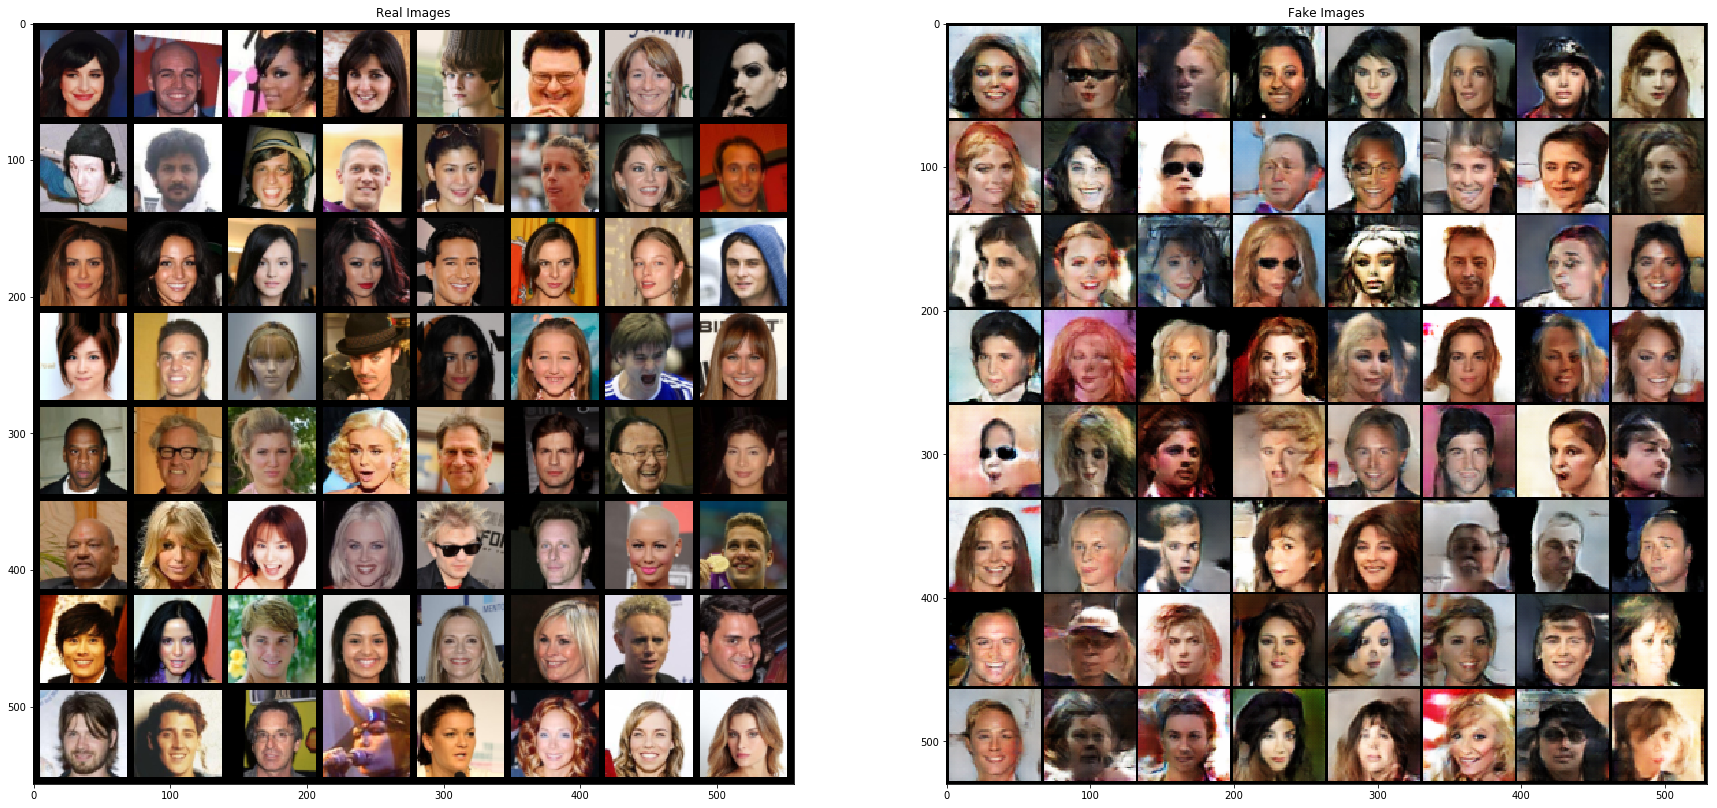

In [14]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis=("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis=("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()